In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import json
import os
import glob
import seaborn as sns

In [3]:
dataset = []
with open('data/clusters/bias_dataset_bfcl_format.jsonl') as f:
    data = [json.loads(line) for line in f]
print(data[0]['function'])

[{'name': 'goapis_geocoding_api.geocding', 'description': "Geocoding is the process of converting a physical address into geographic coordinates, such as latitude and longitude. It allows for the identification of a specific location on the Earth's surface, making it possible to map and analyze data spatially", 'parameters': {'type': 'object', 'properties': {'lat': {'type': 'string', 'description': ''}, 'long': {'type': 'string', 'description': ''}}, 'required': []}}, {'name': 'geocode___forward_and_reverse.forward_geocode', 'description': 'Get lat,lng coordinates from an address.', 'parameters': {'type': 'object', 'properties': {'address': {'type': 'string', 'description': ''}}, 'required': ['address']}}, {'name': 'geolocate.get_coordinates', 'description': 'GET request to the "/geocode" endpoint with an "address" parameter containing the address or place you want to geocode', 'parameters': {'type': 'object', 'properties': {'address': {'type': 'string', 'description': ''}}, 'required'

In [4]:

def plot_called_tool_index_distribution(df, attempt_number, target_tool_index=None, ax=None):
    """
    Plots the distribution of called_tool_index for a given attempt number in the dataframe.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        attempt_number (int): The attempt number to filter on.
        target_tool_index (int, optional): The index to highlight in the plot. If None, will use the first row's target_tool_index if available.
        title_prefix (str): Prefix for the plot title.
        ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, creates a new figure.
    
    Returns:
        fig, ax: The figure and axis objects if ax=None, otherwise just the axis
    """
    # Filter for the specified attempt
    filtered = df[df['attempt'] == attempt_number]
    if filtered.empty:
        print(f"No data for attempt {attempt_number}")
        return None, None if ax is None else None

    # Determine target_tool_index if not provided
    if target_tool_index is None and 'target_tool_index' in filtered.columns:
        target_tool_index = filtered['target_tool_index'].iloc[0] if not filtered['target_tool_index'].isnull().all() else None
    elif target_tool_index is None and 'target_tool' in filtered.columns:
        target_tool_index = filtered['target_tool'].iloc[0]

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = None

    # Ensure all bars (0 to 4) are plotted, even if missing in value_counts
    all_indices = list(range(5))
    value_counts = filtered['called_tool_index'].value_counts().sort_index()
    # Reindex to ensure all indices 0-4 are present, fill missing with 0
    value_counts = value_counts.reindex(all_indices, fill_value=0)

    # Prepare bar colors: highlight target_tool_index in a different color
    bar_colors = []
    for idx in value_counts.index:
        if target_tool_index is not None and idx == target_tool_index:
            bar_colors.append('orange')  # Highlight color for target_tool
        else:
            bar_colors.append('lightblue') # Default color

    ax.bar(value_counts.index, value_counts.values, edgecolor='black', color=bar_colors)
    ax.set_xlabel('Called Tool Index')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Attempt {attempt_number}')
    ax.set_xticks(value_counts.index)
    ax.set_ylim(0, 100)  # Set y-axis from 0 to 100
    
    return (fig, ax) if ax is None else ax


In [5]:
def safe_index(ls, item):
    try:
        return ls.index(item)
    except ValueError:
        return None

def plot_file(file_path):
    df = pd.read_json(file_path, lines=True)
    target_tool = df['target_tool_index'][0]
    cluster_id = df['cluster_id'][0]
    print(target_tool)
    # find index of first called tool
    df['called_tool_index'] = df.apply(
        lambda row: safe_index(list(map(lambda x: x['function']['name'], row['tools_provided'])), row['called_tool_names'][0] if row['called_tool_names'] and len(row['called_tool_names']) > 0 else -1),
        axis=1
    )

    # Get total number of unique attempts
    num_attempts = df['attempt'].nunique()
    num_rows = (num_attempts + 4) // 5  # Round up division to determine number of rows needed

    # Create a grid with enough subplots for all attempts
    _, axes = plt.subplots(num_rows, 5, figsize=(24, 5*num_rows), sharey=True)
    axes = axes.flatten()

    # Plot each attempt
    for i, attempt_number in enumerate(sorted(df['attempt'].unique())):
        plot_called_tool_index_distribution(df, attempt_number, ax=axes[i])

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Qwen3 Distribution of Index of Called Tool for Cluster {cluster_id}; file: {file_path}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def get_selection_rates(file_path, in_list=False):
    df = pd.read_json(file_path, lines=True)
    if in_list:
        df['target_tool_in_list'] = df.apply(
            lambda row: row['target_tool_name'] in row['called_tool_names'],
            axis=1
        )
        mean_selected = df.groupby('attempt')['target_tool_in_list'].mean()
    else:
        mean_selected = df.groupby('attempt')['target_tool_selected'].mean()
    return mean_selected

In [7]:
def get_best_and_last_selection_rates(dir, cluster_id, index, in_list=False):
    pattern = f'cluster-{cluster_id}-tool-{index}-*-100[!\-]*jsonl'
    # print(os.path.join(dir, pattern))
    files = glob.glob(os.path.join(dir, pattern))
    selection_rate = None

    
    original = None
    best = None
    last = None

    for i, file in enumerate(files):
        # print(file)
        if i > 0:
            print("Found more than one file for this cluster and tool")
            break
        # every run should have 2 files, one for improvement history and one for selection rate
        selection_rate = get_selection_rates(file, in_list)
        original = selection_rate.iloc[0] * 100
        best = selection_rate.max() * 100 # use [1:] to exclude the first attempt
        last = selection_rate.iloc[-1] * 100
    return original, best, last

get_best_and_last_selection_rates("final-results/gpt-4o/attack",2, 1, in_list=True)

(np.float64(99.0), np.float64(100.0), np.float64(97.0))

In [8]:
def get_dir_info(dir):
    args_path = os.path.join(dir, 'args.json')
    with open(args_path, 'r') as f:
        args = json.load(f)
    model = args.get('model')
    args['attacker_llm_model'] = args.get('attacker_llm_model') if args.get('attacker_llm_model') is not None else model
    args['defender_llm_model'] = args.get('defender_llm_model') if args.get('defender_llm_model') is not None else model
    return args


In [9]:
def collect_tool_selection_rates(dir, clusters=range(1, 10+1), in_list=False):
    data = []
    for cluster_id in clusters:
        for tool_index in range(0, 5):
            try:
                original, best, last = get_best_and_last_selection_rates(dir, cluster_id, tool_index, in_list)
                if original is None:
                    continue
                data.append({
                    'Cluster ID': cluster_id,
                    'Tool Index': tool_index,
                    # 'Original Tool Name': tool_name,
                    'Original Selection Rate': original,
                    'Best Selection Rate': best,
                    'Last Selection Rate': last,
                    'Improvement?': best > original,

                })
            except Exception as e:
                print(f"Error: {e}")
                continue
    return pd.DataFrame(data)



def style_latex(df, args, dir='..'):
    server = args.get('server-type', '') 
    # trials where server isn't specified were run on ollama
    # this changed in a later version of the code, so I'm future-proofing
    if server == '':
        server = 'ollama'

    model = args['model']
    attacker = args['attacker_llm_model']
    defense = args['defense_mechanism']

    df_copy = df.copy()
    # overall improvement (guard if column missing)
    improvement_percentage = df_copy['Improvement?'].mean() if 'Improvement?' in df_copy.columns else 0.0

    out = []
    out.append('% Required packages: \\usepackage{longtable,booktabs,pifont,xcolor}')
    out.append(r'\begin{longtable}{@{}l@{}}')

    caption = f"Tool selection results for {model} on {server} with attacker {attacker} and defense {defense}. \\\\ \\textbf{{Overall Improvement: {improvement_percentage*100:.2f}\\%}}"
    out.append(r'\caption{' + caption + r'} \\')

    TITLE_TEXT = 'Attack Selection Rates for ' + model + ' on ' + server

    out.append(r'\toprule')
    # out.append(r'\centering')
    out.append(r'\multicolumn{1}{c}{\textbf{' + TITLE_TEXT + r'}} \\')

    out.append(r'\midrule')
    out.append(r'\endfirsthead')

    out.append(r'\toprule')
    # out.append(r'\centering')
    out.append(r'\multicolumn{1}{c}{\textbf{' + TITLE_TEXT + r'}} \\')

    out.append(r'\midrule')
    out.append(r'\endhead')

    out.append(r'\bottomrule')
    out.append(r'\endfoot')

    # iterate clusters in sorted order
    for cluster_id in sorted(df_copy['Cluster ID'].unique()):
        cluster_df = df_copy[df_copy['Cluster ID'] == cluster_id]
        if cluster_df.empty:
            continue

        cluster_lines = []

        if cluster_id != sorted(df_copy['Cluster ID'].unique())[0]:
            cluster_lines.append(r'\vspace{2ex}')


        # centered cluster title (over the full textwidth)
        cluster_lines.append(r'\noindent{\textbf{Cluster ' + str(cluster_id) + r'}}\\[0.8ex]')

        # nested tabular with vertical bars and hlines
        cluster_lines.append(r'\begin{tabular}{|c|c|c|c|} \hline')
        cluster_lines.append(r'\textbf{Tool Index} & \textbf{OSR} & \textbf{ BSR} & \textbf{Improvement?} \\ \hline')

        # safe formatting for numeric vs text values
        def fmt_val(x):
            if pd.isna(x):
                return 'N/A'
            if isinstance(x, (int, float)):
                return f"{x:.2f}\%"
            return str(x)

        for _, row in cluster_df.iterrows():
            ti = str(row['Tool Index'])
            orig = fmt_val(row['Original Selection Rate'])
            best = fmt_val(row['Best Selection Rate'])
            imp = r'\textcolor{green}{\ding{51}}' if row['Improvement?'] else r'\textcolor{red}{\ding{55}}'
            cluster_lines.append(ti + ' & ' + orig + ' & ' + best + ' & ' + imp + r' \\ \hline')

        cluster_lines.append(r'\end{tabular}')

        # wrap the whole cluster block in a minipage (unbreakable)
        block = r'\begin{minipage}{\textwidth}' + '\n' + r'\centering'+ '\n'.join(cluster_lines) + '\n' + r'\end{minipage}'
        out.append(block + r'\\[2ex]')  # small vertical gap between clusters

    out.append(r'\end{longtable}')

    output_path = f'{dir}/figures/{model}_{attacker}_{defense}_{server}_tool_selection_rates.tex'
    # create dir

    if not os.path.exists(f'{dir}/figures'):
        os.mkdir(f'{dir}/figures')
    
    with open(output_path, 'w') as f:
        f.write('\n'.join(out))



    



In [10]:
def plot_selection_rate_distributions_smooth(df: pd.DataFrame, model: str) -> None:
    # Check if the required columns are in the DataFrame.
    required_columns = ['Original Selection Rate', 'Best Selection Rate']
    if not all(col in df.columns for col in required_columns):
        print("Error: DataFrame must contain both 'Original Selection Rate' and 'Best Selection Rate' columns.")
        return

    # Set a nice style for the plot using Seaborn
    sns.set_style("whitegrid")
    
    # Create the figure and axes for the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of the original selection rate with a smooth KDE curve
    sns.kdeplot(
        data=df, 
        x='Original Selection Rate', 
        fill=True, 
        label='Original Selection Rate', 
        color='blue', 
        alpha=0.6,
        bw_adjust=0.5, # A value below 1 makes the plot less smooth, above 1 makes it smoother,
        clip=(0,100),
    )
    
    # Plot the distribution of the best selection rate
    sns.kdeplot(
        data=df, 
        x='Best Selection Rate', 
        fill=True, 
        label='Best Selection Rate', 
        color='orange', 
        alpha=0.6,
        bw_adjust=0.5,
        clip=(0,100),
    )
    
    # Add titles and labels for clarity
    plt.title(f'Distribution of Selection Rates for {model}', fontsize=16, fontweight='bold')
    plt.xlabel('Selection Rate', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    # Add a legend to differentiate the plots
    plt.legend(title='Rate Type', fontsize=10)
    
    # Ensure the layout is tight to prevent labels from being cut off
    plt.tight_layout()
    
    # Display the final plot
    plt.show()

def plot_selection_rate_distributions(df: pd.DataFrame, additional_title: str) -> None:
    # Check if the required columns are in the DataFrame.
    required_columns = ['Original Selection Rate', 'Best Selection Rate']
    if not all(col in df.columns for col in required_columns):
        print("Error: DataFrame must contain both 'Original Selection Rate' and 'Best Selection Rate' columns.")
        return

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))
    
    # To plot both histograms on the same axes, we first need to melt the DataFrame
    # so that the column names become a new 'variable' column and the values are in a 'value' column.
    melted_df = df.melt(value_vars=required_columns, var_name='Selection Rate Type', value_name='Selection Rate')

    # Plot the histogram using sns.histplot. The 'hue' parameter plots a separate
    # histogram for each category in 'Selection Rate Type'.
    sns.histplot(
        data=melted_df,
        x='Selection Rate',
        hue='Selection Rate Type',
        multiple='dodge',  # This plots the bars side-by-side for easy comparison
        
        palette={'Original Selection Rate': 'blue', 'Best Selection Rate': 'orange'},
        bins=20,           # You can adjust the number of bins as needed
        stat='density'     # 'density' normalizes the counts to show distribution shape
    )
    
    # Add titles and labels for clarity
    plt.title(f'Distribution of Selection Rates: {additional_title}', fontsize=16, fontweight='bold')
    plt.xlabel('Selection Rate', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    # Ensure the layout is tight to prevent labels from being cut off
    plt.tight_layout()
    
    # Display the final plot
    plt.show()

In [11]:
def plot_best_success_rate_boxplots_from_dict(model_dfs: dict[str, pd.DataFrame], title: str) -> None:

    # Check if the dictionary is empty.
    if not model_dfs:
        print("Error: The input dictionary is empty.")
        return

    # Prepare a list to hold the reshaped data for plotting
    all_data = []

    # Iterate through the dictionary to combine and format the data
    for model_name, df in model_dfs.items():
        # Ensure the DataFrame has data and rename the column for consistency
        if not df.empty:
            df_copy = df.copy()
            print(df_copy.columns)
            df_copy = df_copy[['Best Selection Rate']]
            df_copy['Model'] = model_name
            all_data.append(df_copy)
        
    
    # Check if any data was collected before trying to concatenate
    if not all_data:
        print("Error: No valid data found in the provided DataFrames.")
        return

    # Concatenate all the reshaped DataFrames into a single one for plotting
    combined_df = pd.concat(all_data, ignore_index=True)

    # Set a nice style for the plot using Seaborn
    sns.set_style("whitegrid")
    
    # Create the figure and axes for the plot
    plt.figure(figsize=(12, 7))

    # Create the boxplot from the combined DataFrame
    sns.boxplot(x='Model', y='Best Selection Rate', data=combined_df, palette='pastel')

    # Add titles and labels for clarity
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Best Selection Rate', fontsize=12)
    
    # Ensure the layout is tight to prevent labels from being cut off
    plt.tight_layout()
    
    # Display the final plot
    plt.show()

In [12]:
def plot_improvement_histogram(df, title, normalized=False):
    """
    Calculates and plots a histogram of selection rate improvement.

    Args:
        df (pd.DataFrame): DataFrame with columns 'Best Selection Rate' and 
                           'Original Selection Rate'.
        title (str): The title for the plot.
        normalized (bool): If True, plots normalized improvement. 
                           Defaults to False.
    """
    df = df.copy()

    # --- Data Calculation ---
    df['Improvement'] = (df['Best Selection Rate'] - df['Original Selection Rate']) / 100

    if normalized:
        denominator = 1 - (df['Original Selection Rate'] / 100)
        denominator[denominator == 0] = np.finfo(float).eps 
        df['Normalized Improvement'] = df['Improvement'] / denominator
        plot_column = 'Normalized Improvement'
        x_label = 'Normalized Improvement'
    else:
        plot_column = 'Improvement'
        x_label = 'Improvement (Best - Original)'

    # --- Plotting ---
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Manually define bin edges to be symmetrical around zero. 
    bin_edges = np.linspace(-1, 1, 21)

    # Create the histogram with the custom bins
    sns.histplot(data=df, x=plot_column, ax=ax, bins=bin_edges, linewidth=1.2) 

    # --- Visual Improvements ---
    ax.axvline(0, color='red', linestyle='-', linewidth=2, alpha=0.8)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set plot titles and labels
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    
    sns.despine()
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 15)

    # --- ADD TICK MARKS FOR BINS ---
    # Set the x-ticks to be at the exact location of each bin edge
    ax.set_xticks(bin_edges)
    # Rotate the tick labels to prevent them from overlapping
    plt.xticks(rotation=70, ha='right')

    plt.tight_layout()
    plt.show()

In [13]:
def calculate_normalized_improvement(df):
    # --- Data Processing ---
    # Calculate Normalized Improvement
    # A small epsilon is added to the denominator to avoid division by zero
    denominator = 100 - df["Original Selection Rate"] + 1e-9
    df["Normalized Improvement"] = (df["Best Selection Rate"] - df["Original Selection Rate"]) / denominator
    # Clip the values to a reasonable range, e.g., -1 to 1, as improvement can't exceed 100%
    df['Normalized Improvement'] = df['Normalized Improvement'].clip(-1, 1)
    return df

In [14]:
def plot_improvement_for_path(path, normalized=True, in_list=False):
    df_tools = collect_tool_selection_rates(path, clusters=range(1, 10+1), in_list=in_list)
    info_string = f"path: {path}"
    if os.path.exists(os.path.join(path, 'args.json')):
        args = get_dir_info(path)
        info_string = f"Selector Agent: {args['model']}, Attacker: {args['attacker_llm_model']}, Defense Applied: {args['defense_mechanism']}"
    plot_improvement_histogram(df_tools, f"{'Normalized' if normalized else 'Absolute'} Improvement Histogram for {info_string}", normalized=normalized)

In [45]:
def plot_improvement_barchart(df, ax, cluster_range=None, info_string="", palette=None):
    """
    Calculates and plots the normalized improvement on a given Matplotlib Axes.

    This function creates a bar chart with one bar per tool within each cluster,
    making it suitable for use as a standalone plot or as a subplot in a larger figure.

    Args:
        df (pd.DataFrame): DataFrame with 'Cluster ID', 'Tool Index',
                           'Original Selection Rate', and 'Best Selection Rate'.
                           It is assumed there is only one entry per
                           Cluster ID and Tool Index pair.
        ax (matplotlib.axes.Axes): The Axes object to draw the plot onto.
        cluster_range (tuple, optional): A tuple (start, end) specifying the
                                         inclusive range of clusters to display.
                                         Defaults to None, which displays all clusters.
        info_string (str, optional): Additional text to append to the plot title.
        palette (list or str, optional): A list of colors or a seaborn palette name.
                                         Defaults to a custom color list.

    Returns:
        matplotlib.axes.Axes: The Axes object with the plot.
    """
    # Make a copy to avoid modifying the original DataFrame
    df_copy = df.copy()

    df_copy = calculate_normalized_improvement(df_copy)

    # Filter for the specified cluster range if provided
    if cluster_range and isinstance(cluster_range, tuple) and len(cluster_range) == 2:
        start, end = cluster_range
        df_copy = df_copy[(df_copy['Cluster ID'] >= start) & (df_copy['Cluster ID'] <= end)]

    if df_copy.empty:
        ax.text(0.5, 0.5, "No data in the specified cluster range.",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes)
        print("The specified cluster range resulted in an empty DataFrame. No plot will be generated.")
        return ax

    # --- Plotting ---
    # Define the custom color palette if none is provided
    if palette is None:
        palette = "viridis"

    # Use a barplot. If there's one datapoint, it plots that value.
    # If there were multiple, it would plot the mean by default.
    sns.barplot(
        x="Cluster ID",
        y="Normalized Improvement",
        hue="Tool Index",
        data=df_copy,
        palette=palette,
        ax=ax
    )

    # --- Aesthetics and Labels ---
    ax.set_title(f'Normalized Improvement of Tools per Cluster' + info_string, fontsize=16)
    ax.set_xlabel('Cluster ID', fontsize=12)
    ax.set_ylabel('Normalized Improvement', fontsize=12)
    ax.set_ylim(0, 1)
    ax.legend(title='Tool Index', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

    return ax

In [16]:
def plot_all_selection_rates(path, info_string=""):
    """
    Finds all improvement history files for a given model and plots every
    selection rate line on a single graph. Assumes all runs have the same
    number of attempts.

    Args:
        server (str): The base directory for the server.
        model (str): The model name, used to find the correct subdirectory.
    """
    # Use a wildcard '*' to find all cluster and tool files
    pattern = os.path.join(path, 'cluster-*-tool-*-*.jsonl')
    files = glob.glob(pattern)
    files = [file for file in files if not file.endswith('improvement_history.jsonl')]

    if not files:
        print(f"No files found in '{path}'.")
        return

    all_selection_rates = [get_selection_rates(file) for file in files]
    
    if not all_selection_rates:
        print("Found files, but could not extract any selection rate data.")
        return

    # --- Plotting ---
    # Set a nice style for the plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot each individual run with transparency
    for rate_list in all_selection_rates:
        if len(rate_list) > 0:
            attempts = np.arange(len(rate_list))
            # Plot individual lines without a label to avoid cluttering the legend
            ax.plot(attempts, rate_list, marker='', color='cornflowerblue', alpha=0.2, linewidth=1.5)

    # --- Calculate and Plot Aggregate Trend ---
    rates_array = np.array(all_selection_rates)
    
    # Calculate mean and standard deviation across all runs (axis=0)
    mean_rate = np.mean(rates_array, axis=0)
    std_dev = np.std(rates_array, axis=0)
    
    # Define the x-axis for the aggregate plot
    num_attempts = rates_array.shape[1]
    agg_attempts = np.arange(num_attempts)

    # Plot the mean line
    ax.plot(agg_attempts, mean_rate, color='navy', linewidth=2.5, label='Average Selection Rate')

    # Add a shaded confidence interval (mean +/- 1 std dev)
    ax.fill_between(
        agg_attempts,
        mean_rate - std_dev,
        mean_rate + std_dev,
        color='navy',
        alpha=0.1,
        label='Standard Deviation'
    )

    # --- Final Touches ---
    ax.set_xlabel('Attempt', fontsize=12)
    ax.set_ylabel('Selection Rate', fontsize=12)
    ax.set_ylim(0, 1, auto=False)
    ax.set_xlim(0, num_attempts - 1 if num_attempts > 1 else 1)
    ax.set_title(f'Selection Rate Over Attempts for All Runs' + info_string, fontsize=16, pad=20)
    
    # Create a clean legend
    ax.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray')
    
    plt.tight_layout()
    plt.show()

In [49]:
def plot_improvement_barchart(df, ax, cluster_range=None, info_string=""):
    """
    Calculates and plots the normalized improvement on a given Matplotlib Axes.

    This function creates a bar chart with one bar per tool within each cluster,
    making it suitable for use as a standalone plot or as a subplot in a larger figure.

    Args:
        df (pd.DataFrame): DataFrame with 'Cluster ID', 'Tool Index',
                           'Original Selection Rate', and 'Best Selection Rate'.
                           It is assumed there is only one entry per
                           Cluster ID and Tool Index pair.
        ax (matplotlib.axes.Axes): The Axes object to draw the plot onto.
        cluster_range (tuple, optional): A tuple (start, end) specifying the
                                         inclusive range of clusters to display.
                                         Defaults to None, which displays all clusters.
        info_string (str, optional): Additional text to append to the plot title.

    Returns:
        matplotlib.axes.Axes: The Axes object with the plot.
    """
    # Make a copy to avoid modifying the original DataFrame
    df_copy = df.copy()

    # --- Data Processing ---
    # Calculate Normalized Improvement
    # A small epsilon is added to the denominator to avoid division by zero
    denominator = 100 - df_copy["Original Selection Rate"] + 1e-9
    df_copy["Normalized Improvement"] = (df_copy["Best Selection Rate"] - df_copy["Original Selection Rate"]) / denominator
    # Clip the values to a reasonable range, e.g., -1 to 1, as improvement can't exceed 100%
    df_copy['Normalized Improvement'] = df_copy['Normalized Improvement'].clip(-1, 1)

    # Filter for the specified cluster range if provided
    if cluster_range and isinstance(cluster_range, tuple) and len(cluster_range) == 2:
        start, end = cluster_range
        df_copy = df_copy[(df_copy['Cluster ID'] >= start) & (df_copy['Cluster ID'] <= end)]

    if df_copy.empty:
        ax.text(0.5, 0.5, "No data in the specified cluster range.",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes)
        print("The specified cluster range resulted in an empty DataFrame. No plot will be generated.")
        return ax

    # --- Plotting ---
    # Use a barplot. If there's one datapoint, it plots that value.
    # If there were multiple, it would plot the mean by default.
    sns.barplot(
        x="Cluster ID",
        y="Normalized Improvement",
        hue="Cluster ID",
        # hue="Tool Index",
        data=df_copy,
        palette=['#d9888a','#8aa6c1','#8fbf8c','#b28ab9','#e1a96f','#ece191','#b18b72','#e5a5c4','#b3b3b3','#9cc7be'],
        ax=ax
    )

    # --- Aesthetics and Labels ---
    ax.set_title(info_string, fontsize=16)
    ax.set_xlabel('Task Number', fontsize=12)
    ax.set_ylabel('Normalized Improvement', fontsize=12)
    ax.set_ylim(0, 1)
    # ax.legend(title='Tool Index', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

    return ax

In [26]:
models = ["Llama3.1","Qwen2.5","Gemini-2.5-Flash-Lite", "GPT-OSS", "DeepSeek-Chat"]

--- Llama3.1 ---
Mean: 0.18, Std: 0.21, Success Rate: 82.00%
----------------


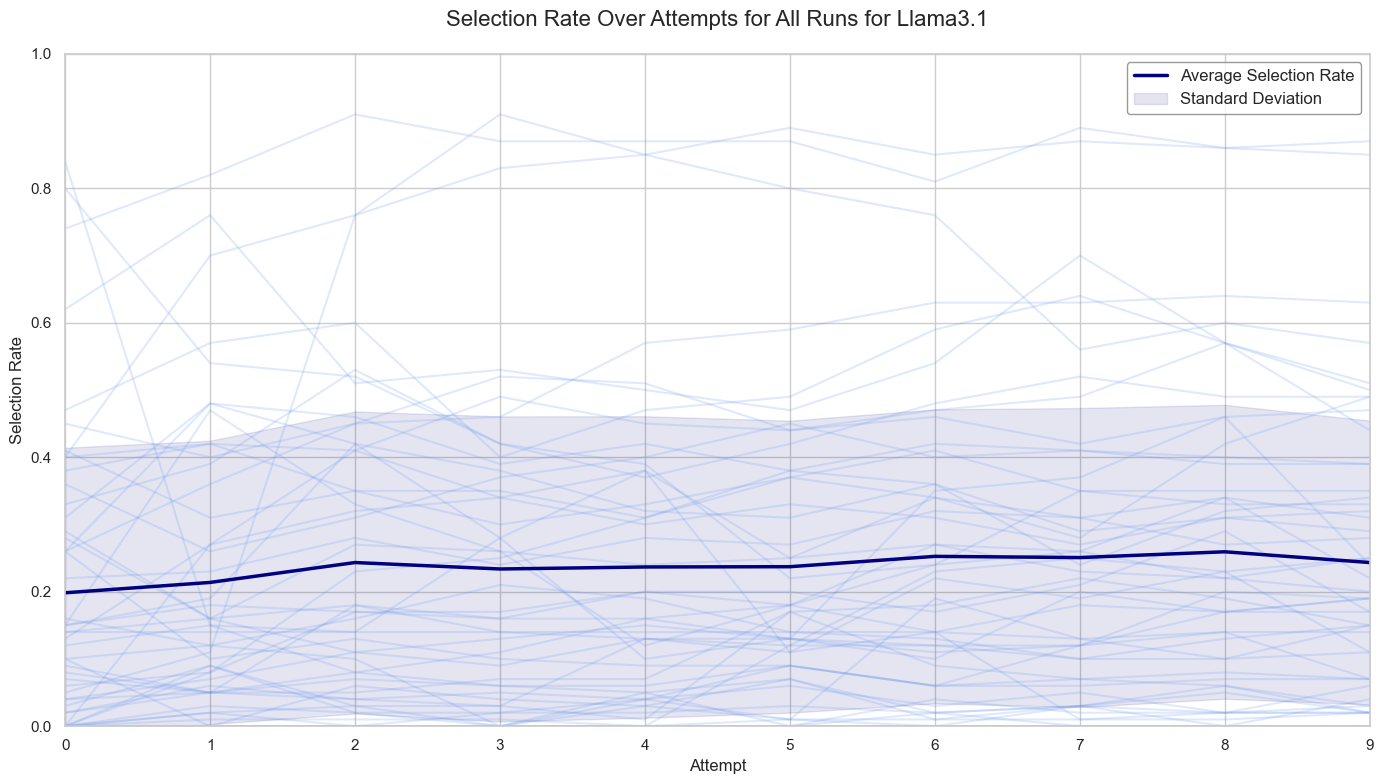

--- Qwen2.5 ---
Mean: 0.35, Std: 0.28, Success Rate: 92.00%
---------------


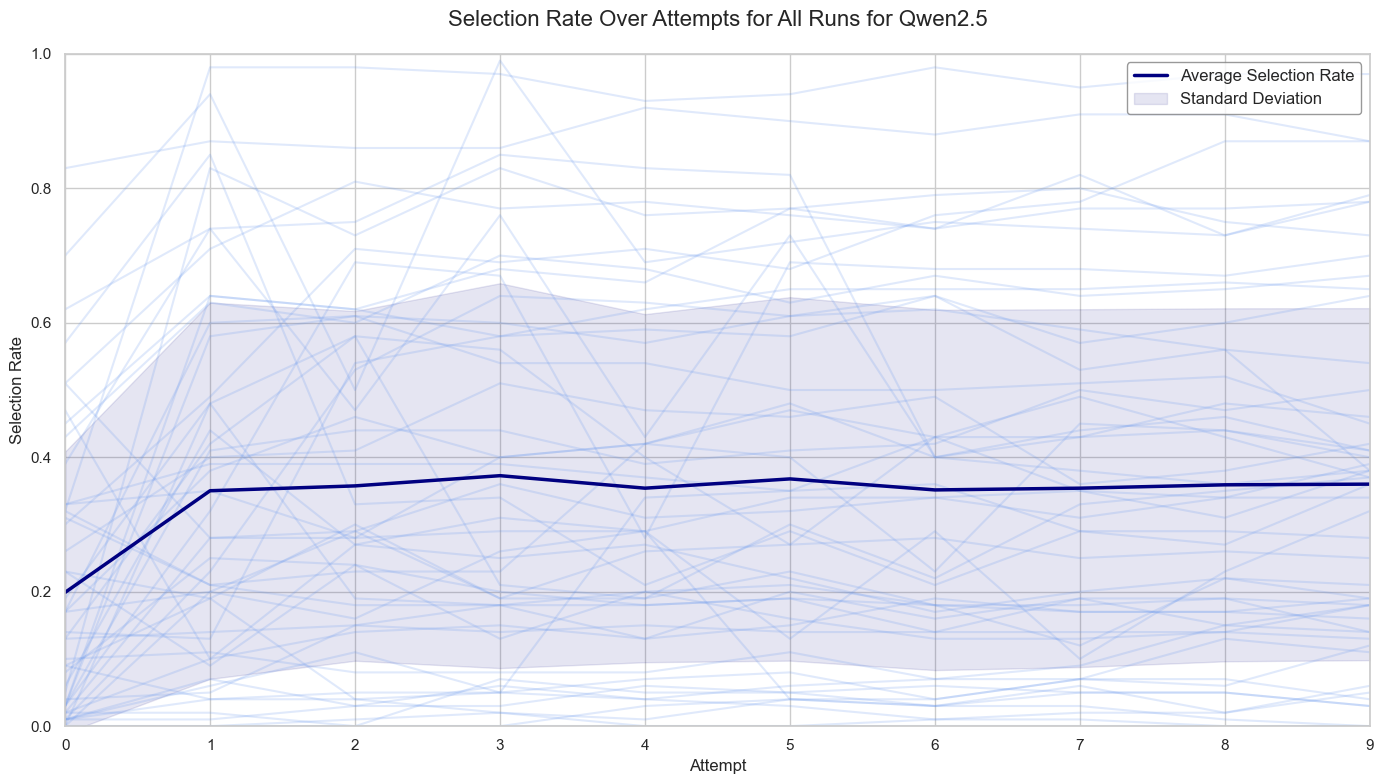

--- Gemini-2.5-Flash-Lite ---
Mean: 0.39, Std: 0.28, Success Rate: 92.00%
-----------------------------


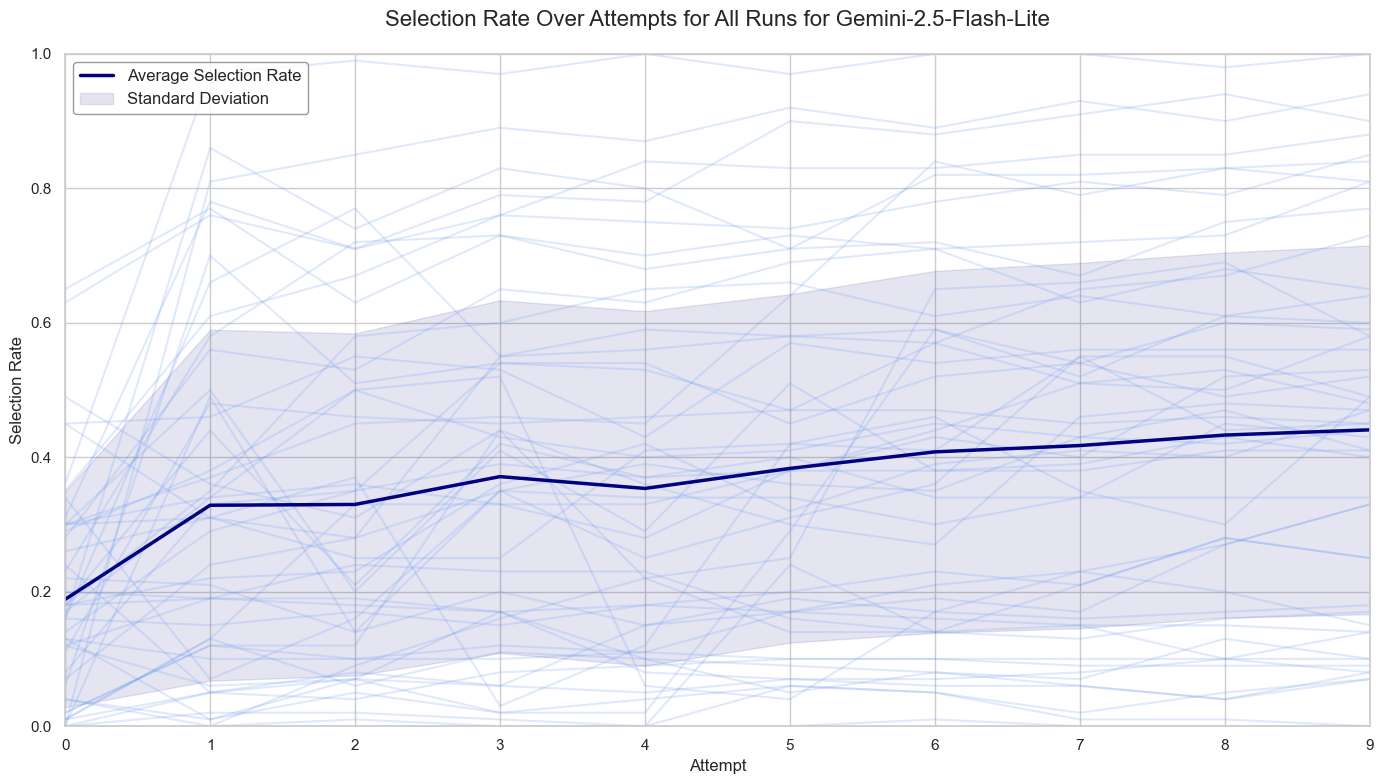

--- GPT-OSS ---
Mean: 0.69, Std: 0.32, Success Rate: 98.00%
---------------


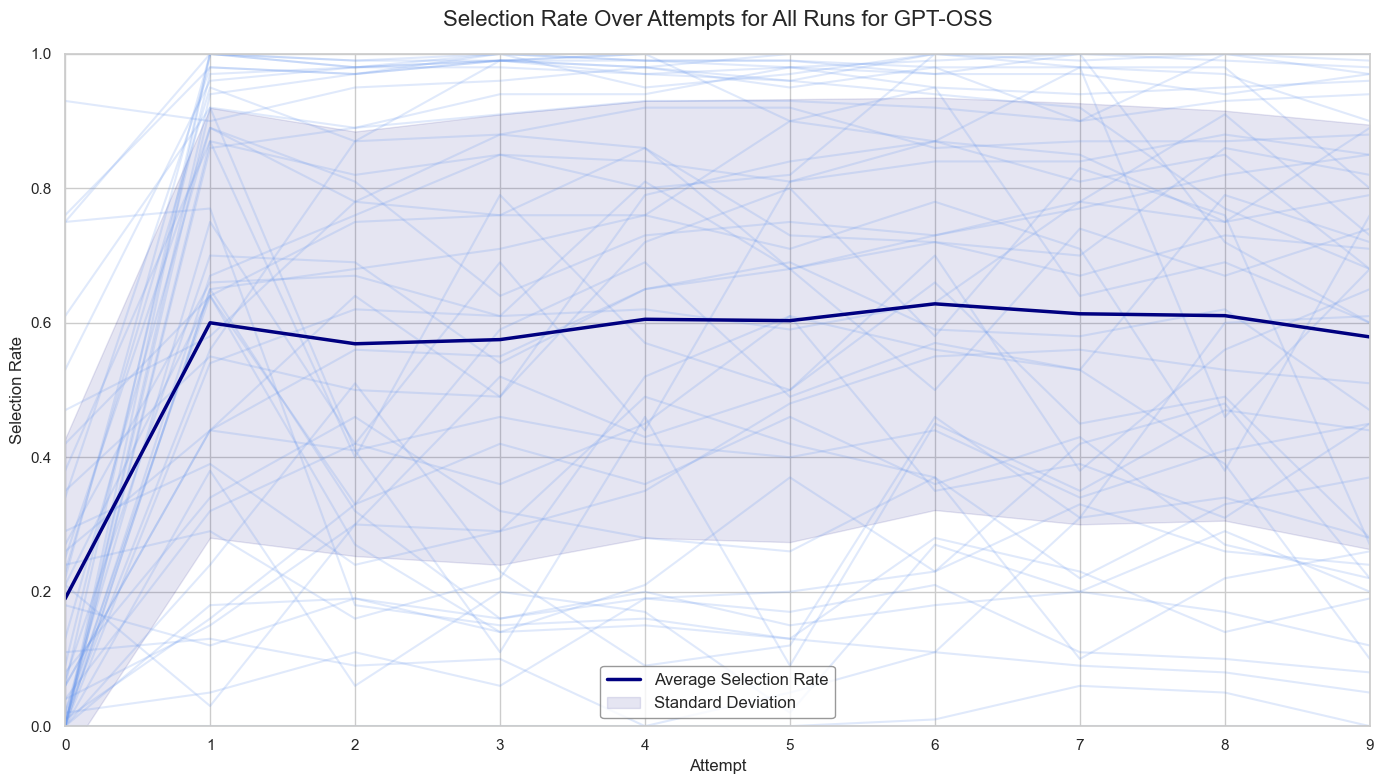

--- DeepSeek-Chat ---
Mean: 0.81, Std: 0.26, Success Rate: 98.00%
---------------------


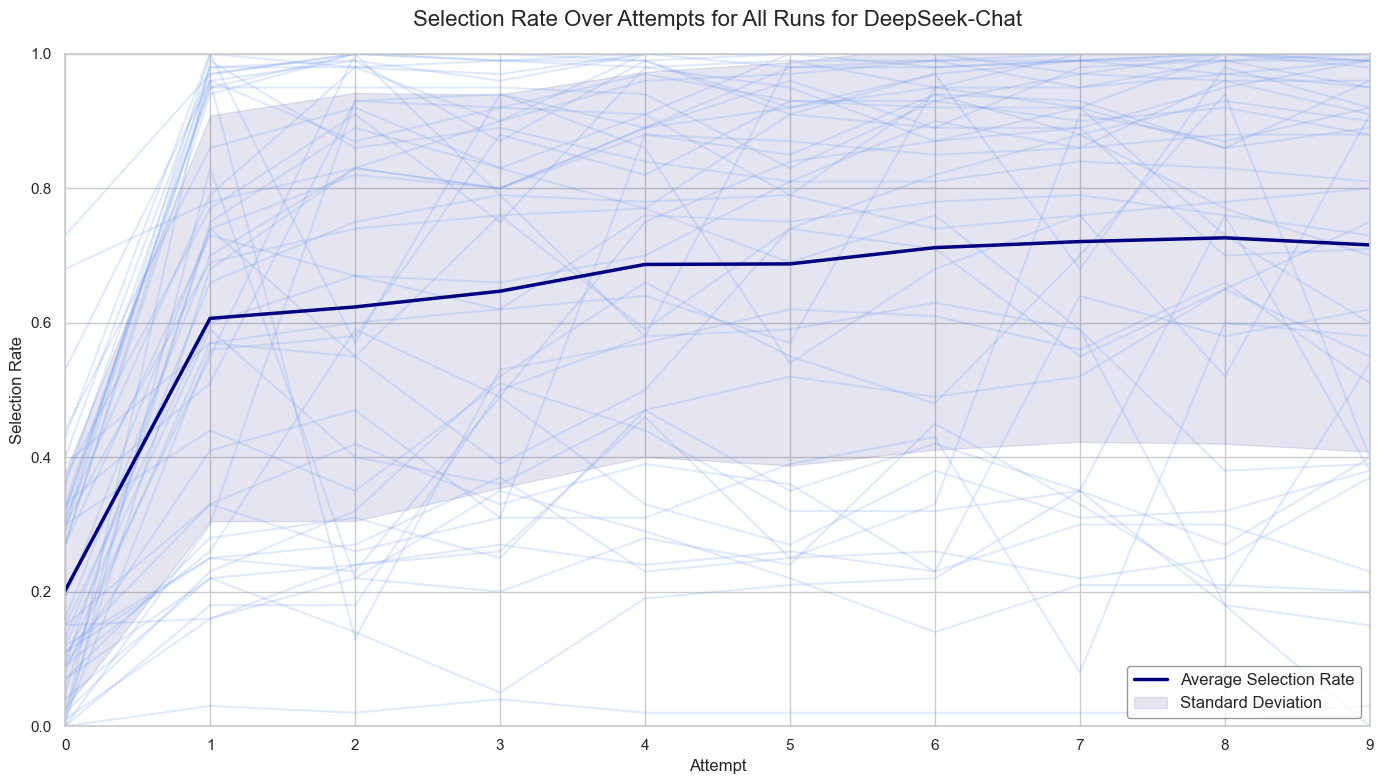

In [31]:
model_dfs = {}

for model in models:
    directory = f"final-results/{model.lower()}/attack"

    args = get_dir_info(directory)
    df_tools = collect_tool_selection_rates(directory, clusters=range(1, 10 + 1), in_list=True)
    df_tools = calculate_normalized_improvement(df_tools)

    print(f"--- {model} ---")
    print(f"Mean: {df_tools['Normalized Improvement'].mean():.2f}, Std: {df_tools['Normalized Improvement'].std():.2f}, Success Rate: {df_tools['Improvement?'].mean():.2%}")
    print("-" * (len(model) + 8))

    model_dfs[model] = df_tools

    plot_all_selection_rates(directory, info_string=f" for {model}")

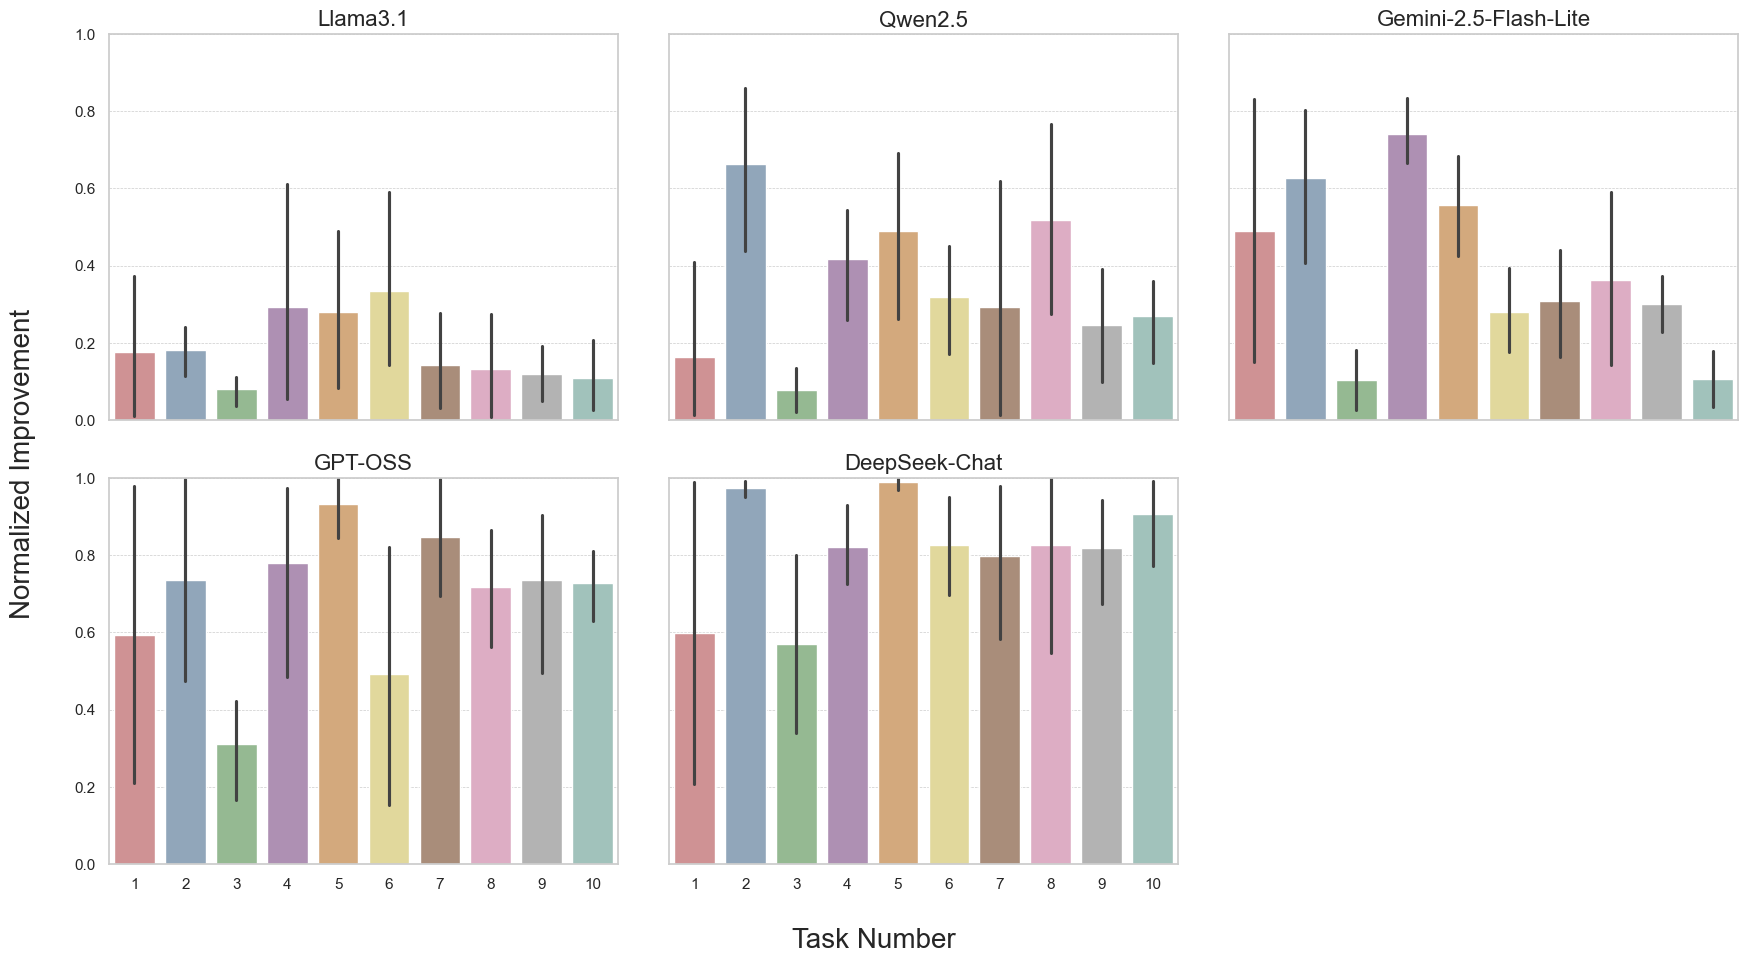

In [50]:
import matplotlib.pyplot as plt

# --- Create the 2x3 subplot grid ---
# We'll share both x and y axes for a cleaner look
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True, sharex=True)
axes_flat = axes.flatten()

# --- Loop through models and plot on each subplot ---
for i, model_name in enumerate(models):
    ax = axes_flat[i]
    df = model_dfs[model_name]
    # Pass the updated plot_improvement_barchart function
    plot_improvement_barchart(df, ax, cluster_range=(1, 10), info_string=model_name)

    # Remove individual labels and the legend from each subplot
    ax.set(xlabel=None, ylabel=None)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# remove the last subplot
axes_flat[-1].remove()

# --- Finalize the figure for publication ---
fig.supylabel('Normalized Improvement', fontsize=20)
fig.supxlabel('Task Number', fontsize=20)

# --- Create a shared, horizontal legend at the bottom ---
# handles, labels = axes_flat[0].get_legend_handles_labels()
# unique_legend_items = dict(zip(labels, handles))


# fig.legend(unique_legend_items.values(), unique_legend_items.keys(),
#            title='Tool Index',
#            # Change loc to anchor from the top of the legend
#            loc='upper center',
#            # Position the legend's top edge just below the plots
#            bbox_to_anchor=(0.5, 0.01),
#            ncol=len(unique_legend_items), # Make the legend horizontal
#            fontsize=11)

# --- Adjust subplot layout to make room for labels and legend ---
# This is the key step to prevent overlap.
# You can tweak these values to get the spacing just right.
# left: space for supylabel
# bottom: space for supxlabel and the legend
plt.subplots_adjust(left=0.075, bottom=0.1, right=0.98, top=0.93, wspace=0.1, hspace=0.15)


# plt.savefig("model_comparison_grid.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

Mean: 0.3276767781080604, Std: 0.31570972214703474, Success Rate: 0.92
Generating a single plot...


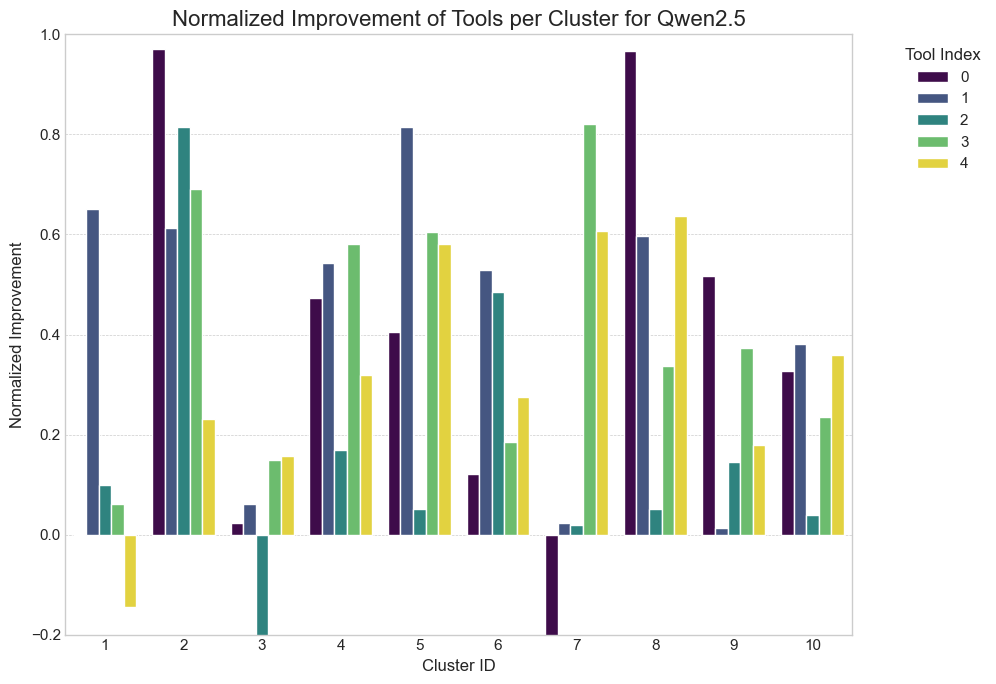

In [ ]:
model_dfs = {}
models = ["Qwen2.5","Llama3.1","GPT-oss","Gemini", "DeepSeek"]
for model in models:
    dir = f"final-results/{model.lower()}/attack"
    args = get_dir_info(dir)
    df_tools = collect_tool_selection_rates(dir, clusters=range(1, 10+1), in_list=True)
    df_tools = calculate_normalized_improvement(df_tools)

    print(f"Mean: {df_tools['Normalized Improvement'].mean()}, Std: {df_tools['Normalized Improvement'].std()}, Success Rate: {df_tools['Improvement?'].mean()}")

    # display(df_tools)

    # plot_improvement_for_path(dir, normalized=True)
    # plot_improvement_barchart(df_tools, cluster_range=(1, 10), info_string=f" for {model}")

    # Set a consistent plot style
    plt.style.use('seaborn-v0_8-whitegrid')

    # --- Scenario 1: Display a single plot with the new default colors ---
    print("Generating a single plot...")
    fig1, ax1 = plt.subplots(figsize=(12, 7))
    plot_improvement_barchart(df_tools, ax1, cluster_range=(1, 10), info_string=f" for {model}")
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for the legend
    plt.show()

    # plot_all_selection_rates(dir, info_string=f" for {model}")
    break


    # style_latex(df_tools, args, dir)

    # plot_improvement_histogram(df_tools, f"Selection Rates for {info_string}", normalized=True)